In [1]:
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import math

In [2]:
nx = 64 # number of computational grids along x direction
number_of_grain = 3 # total number of grains: N
dx = 0.5e-6 # spacing of computational grids [m]
nsteps = 4000# total number of time-steps
pi = np.pi 
sigma = 1.0 # grain boundary energy [J/m2]
amobi = 1.0e-13 # grain boundary mobility [m4/(Js)]
delta = 6.0 * dx # thickness of diffuse interface
eee = 1.0e+6 # magnitude of driving force

In [3]:
aaa = 2.0 / pi * np.sqrt(2.0*delta*sigma) # gradient energy coefficient
www = 4.0 * sigma/delta # height of double-obstacle potential
pmobi = pi*pi/(8.*delta)*1.0e-13 # mobility of phase-field 
dt = dx*dx/(5.*pmobi*aaa*aaa)/10 # time increment [s]

In [4]:
wij = np.zeros((number_of_grain,number_of_grain)) # array for the height of double-obstacle potential
aij = np.zeros((number_of_grain,number_of_grain)) # array for the gradient energy coefficient
mij = np.zeros((number_of_grain,number_of_grain)) # array for the mobility of phase-field 
eij = np.zeros((number_of_grain,number_of_grain)) # arrays for saving the magnitude of driving foce of grain boundary migration

In [5]:
phi = np.zeros((number_of_grain,nx)) 
phi_new = np.zeros((number_of_grain,nx)) 
mf = np.zeros((15,nx),dtype = int) 
nf = np.zeros((nx),dtype = int) 

In [6]:
for i in range(0,number_of_grain):
    for j in range(0,number_of_grain):
        wij[i,j] = www
        aij[i,j] = aaa
        mij[i,j] = pmobi
        eij[i,j] = 0.0
        if i == j:
            wij[i,j] = 0.0
            aij[i,j] = 0.0
            mij[i,j] = 0.0
        if i == 0 or j == 0:
            eij[i,j] = eee
        if i < j:
            eij[i,j] = -eij[i,j]

In [7]:
def update_nfmf(phi,mf,nf):
    for l in range(nx):
        l_p = l + 1
        l_m = l - 1
        if l_p > nx-1:
            l_p = l_p - nx
        if l_m < 0:
            l_m = l_m + nx
        n = 0
        for i in range(number_of_grain):
            if phi[i,l] > 0.0 or (phi[i,l] == 0.0 and phi[i,l_p] > 0.0 or phi[i,l_m] > 0.0):
                n += 1
                mf[n-1,l] = i
        nf[l] = n

In [8]:
def update_phasefield(phi,phi_new,mf,nf,eij):
    for l in range(nx):
        l_p = l + 1
        l_m = l - 1
        if l_p > nx-1: 
            l_p = l_p - nx
        if l_m < 0:
            l_m = l_m + nx
        for n1 in range(nf[l]):
            i = mf[n1,l]
            dpi = 0.0
            for n2 in range(nf[l]):
                j = mf[n2,l]
                ppp = 0.0
                for n3 in range(nf[l]):
                    k = mf[n3,l]
                    ppp += (wij[i,k]-wij[j,k])*phi[k,l]+0.5*(aij[i,k]**2 - aij[j,k]**2)*(phi[k,l_p]-2.0*phi[k,l]+phi[k,l_m])/dx/dx
                    phii_phij = phi[i,l]*phi[j,l]
                    dpi = dpi - 2.0 * mij[i,j] / float(nf[l]) * (ppp - 8./pi*np.sqrt(phii_phij)*eij[i,j])
            phi_new[i,l] = phi[i,l] + dpi *dt

    phi_new = np.where(phi_new <= 0.0,0.0,phi_new)
    phi_new = np.where(phi_new >= 1.0,1.0,phi_new)

    for l in range(nx):
        a = np.sum(phi_new[:,l])
        phi[:,l] = phi_new[:,l] / a

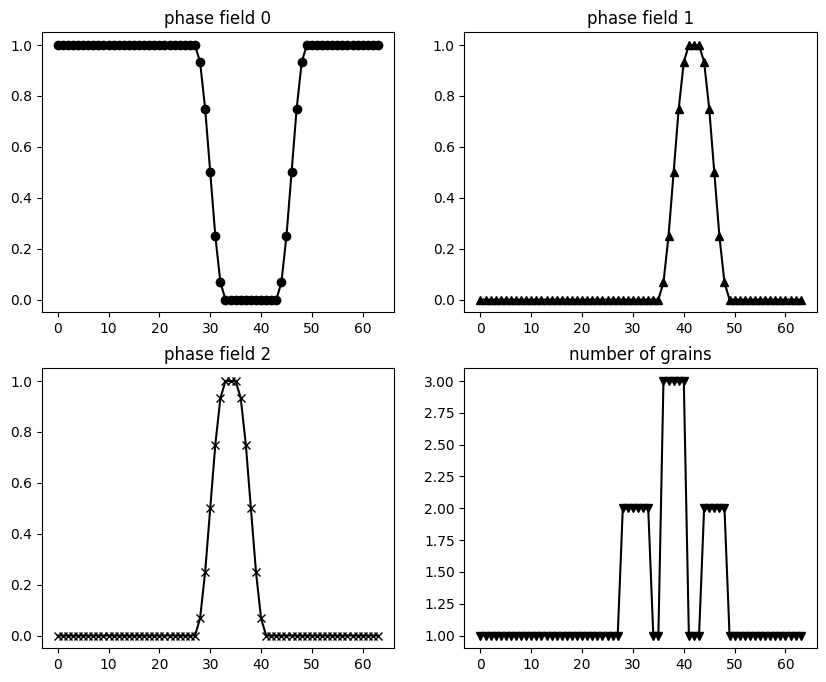

In [9]:
phi = np.zeros((number_of_grain,nx))
phi_new = np.zeros((number_of_grain,nx))
mf = np.zeros((15,nx),dtype = int)
nf = np.zeros((nx),dtype = int)

phi[0,:] = 1.0
nf[:] = 1
r_nuclei = 4.*dx # radius of the initial grains

for i in range(1,number_of_grain):
    x_nuclei = int(rand()*nx)
    for l in range(nx):
        if l > nx-1: 
            l = l - nx
        if l < 0:
            l = l + nx
        r = np.sqrt( (l *dx-x_nuclei*dx)**2) - r_nuclei
        tmp = np.sqrt(2.*www)/aaa*r
        phi_tmp = 0.5*(1.-np.sin(tmp))
        if tmp >= pi/2.:
            phi_tmp=0.
        if tmp <= -pi/2.:
            phi_tmp=1.
            nf[l] = nf[l] -1
        if phi_tmp > 0: 
            nf_tmp = nf[l]+1
            nf[l] = nf_tmp
            mf[nf_tmp,l] = i
            phi[i,l] = phi_tmp            
            phi[0,l] = phi[0,l]-phi[i,l]

fig = plt.figure(figsize=(10,8))
fig.set_dpi(100)
plt.subplots_adjust(hspace=0.2)

plt.subplot(2,2, 1)
plt.plot(phi[0,:],color="k",marker="o")
plt.title('phase field 0')
plt.subplot(2,2, 2)
plt.plot(phi[1,:],color="k",marker="^")
plt.title('phase field 1')
plt.subplot(2,2, 3)
plt.plot(phi[2,:],color="k",marker="x")
plt.title('phase field 2')
plt.subplot(2,2, 4)
plt.plot(nf[:],color="k",marker="v")
plt.title('number of grains')
plt.show()

nstep =  500


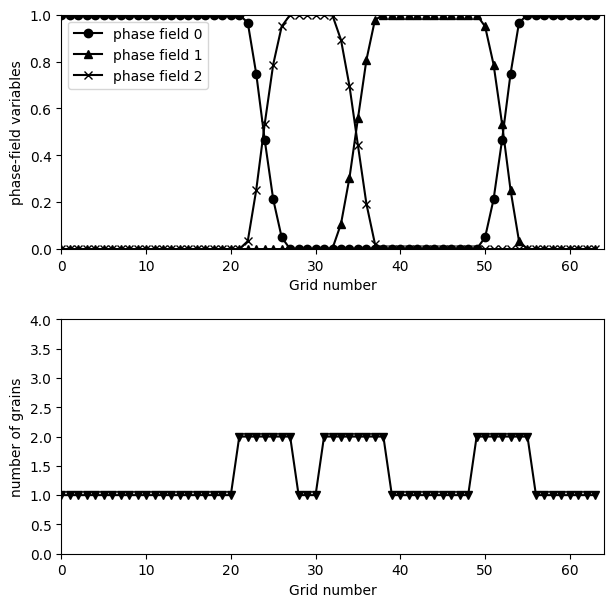

nstep =  1000


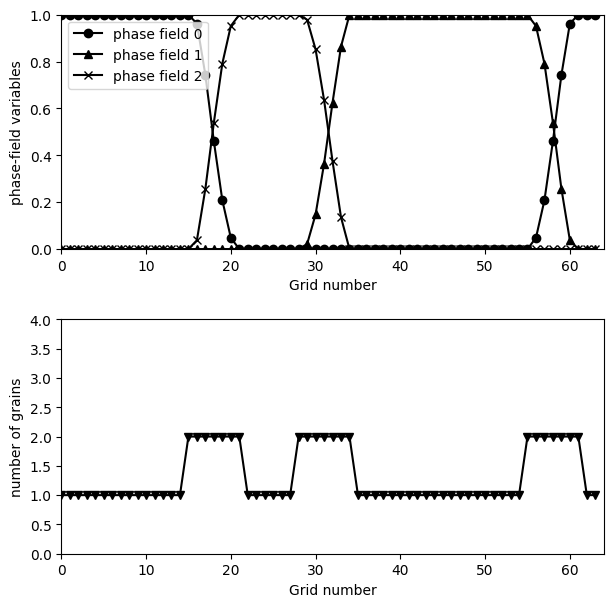

nstep =  1500


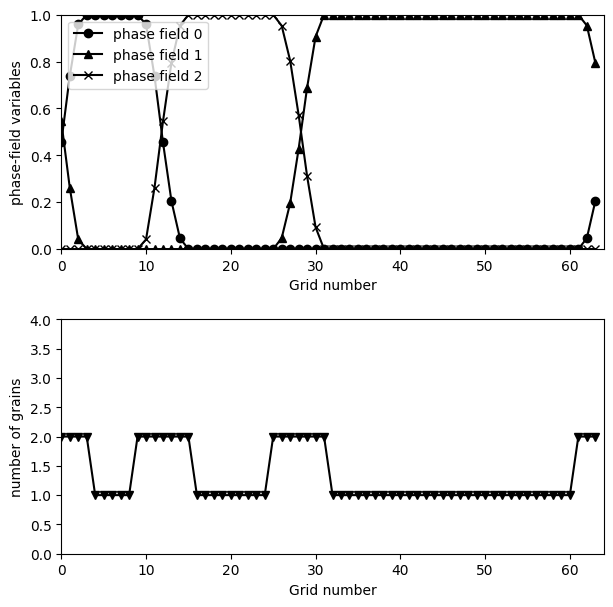

nstep =  2000


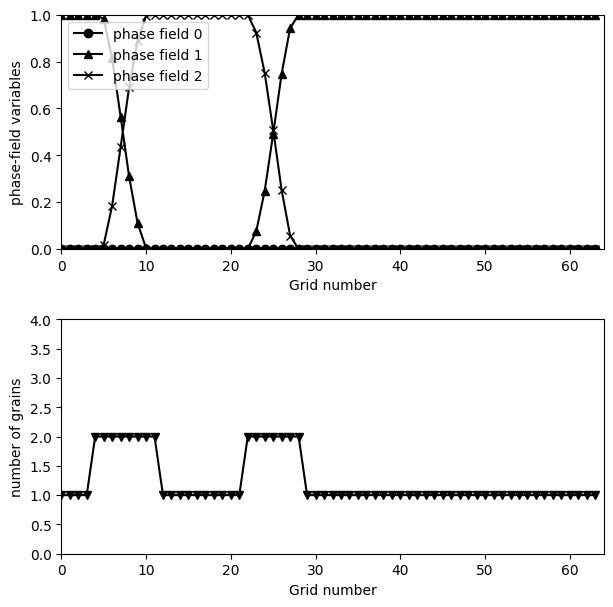

nstep =  2500


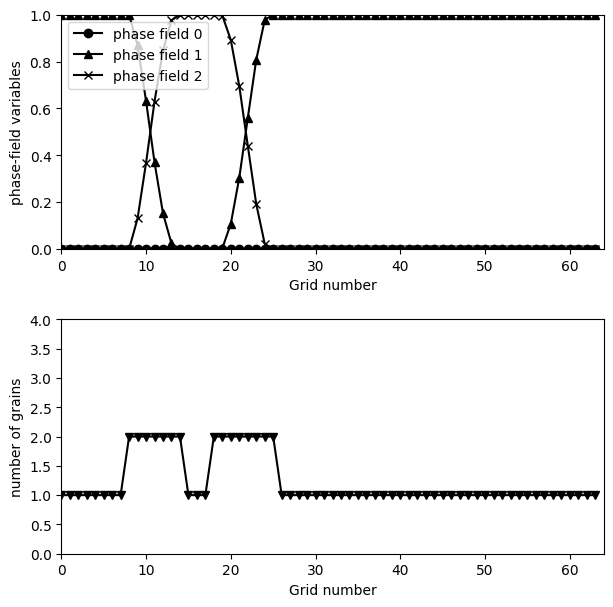

nstep =  3000


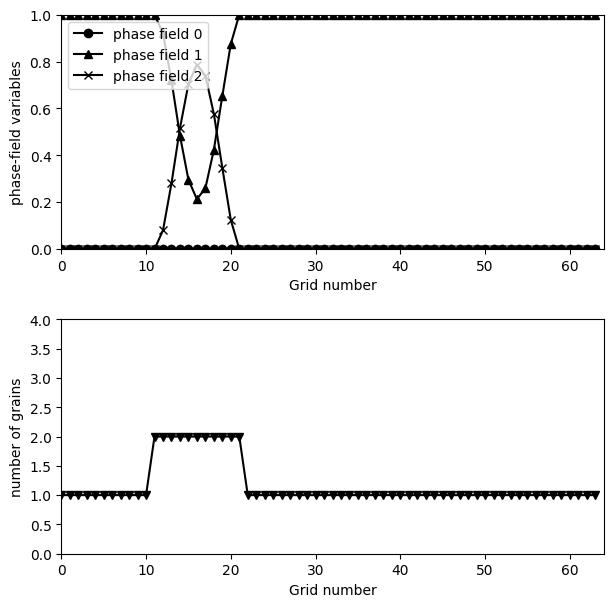

nstep =  3500


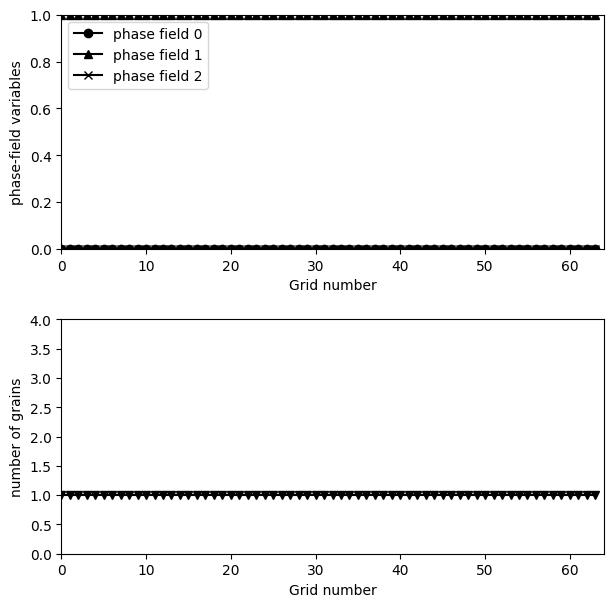

nstep =  4000


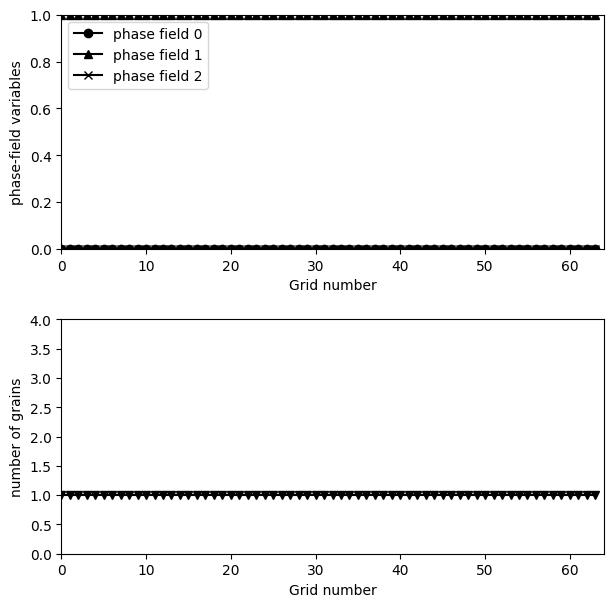

In [10]:
for nstep in range(1,nsteps+1):
    update_nfmf(phi,mf,nf)
    update_phasefield(phi,phi_new,mf,nf,eij)
    
    if nstep % 500 == 0:
        print('nstep = ', nstep)

        fig = plt.figure(figsize=(7,7))
        fig.set_dpi(100)
        plt.subplots_adjust(hspace=0.3)

        plt.subplot(2,1, 1)
        plt.ylim([0,1])
        plt.xlim([0,nx])
        plt.xlabel('Grid number')
        plt.ylabel('phase-field variables')
        plt.plot(phi[0,:],color="k",marker="o",label="phase field 0")
        plt.legend(loc="upper left")
        plt.subplot(2,1, 1)
        plt.plot(phi[1,:],color="k",marker="^",label="phase field 1")
        plt.legend(loc="upper left")
        plt.subplot(2,1, 1)
        plt.plot(phi[2,:],color="k",marker="x",label="phase field 2")
        plt.legend(loc="upper left")
        plt.subplot(2,1, 2)
        plt.xlim([0,nx])
        plt.ylim([0,4])
        plt.xlabel('Grid number')
        plt.ylabel('number of grains')
        plt.plot(nf[:],color="k",marker="v")
        plt.show()